In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

def custom_sat_cmap(basecolor, num, min_s=0.001):

    hsv = rgb_to_hsv(basecolor).tolist()
    new_s_lst = np.linspace(min_s, hsv[1], num)

    new_cmap = []
    for new_s in new_s_lst:
        hsv[1] = new_s
        new_cmap.append(hsv_to_rgb(hsv).tolist())

    return new_cmap


def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_t20c = mpl.color_sequences['tab20c']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

In [3]:
alpha = 0.2

n_neg = [80, 70, 60, 50, 20, 100]
n_pos = [100-cnt for cnt in n_neg]

n_neg_mined = [n if (p >= n) or p==0 else alpha*(n - p) + p for (n, p) in zip(n_neg, n_pos)]

n_neg_deleted = [x-y for (x,y) in zip(n_neg,n_neg_mined)]

c_bal_weights = [p/k if p!=0 else 1 for (p, k) in zip(n_pos, n_neg_mined)]

In [4]:
data = {
    'Non-Target (Selected)':n_neg_mined,
    'Non-Target (Deleted)':n_neg_deleted,
    'Target':n_pos,
}

data, c_bal_weights

({'Non-Target (Selected)': [32.0, 38.0, 44.0, 50, 20, 100],
  'Non-Target (Deleted)': [48.0, 32.0, 16.0, 0, 0, 0],
  'Target': [20, 30, 40, 50, 80, 0]},
 [0.625, 0.7894736842105263, 0.9090909090909091, 1.0, 4.0, 1])

Text(0.5, 1.0, 'Hard Negative Mining Results ($\\alpha=$0.2)')

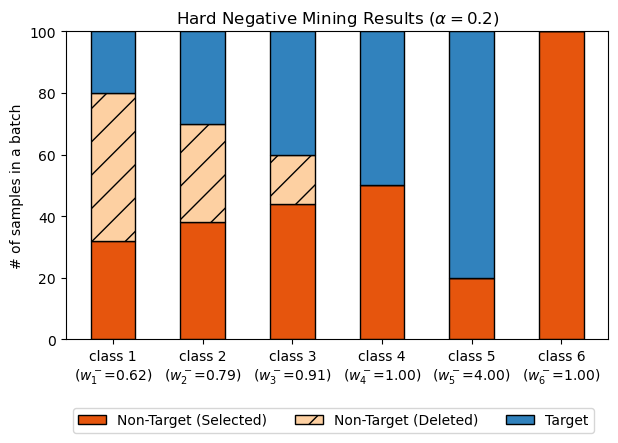

In [5]:
bottom = np.zeros(6)
width = 0.5
cases = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
cases = [f"{c}\n($w^-_{idx+1}$={c_bal_weights[idx]:.2f})" for idx,c in enumerate(cases)]
hatch = ['','/','']
color = [CMAP_t20c[4],CMAP_t20c[7],CMAP_t20c[0]]

fig, ax1 = plt.subplots(figsize=(7,4))

for idx, (label, sample_cnt) in enumerate(data.items()):
    ax1.bar(cases, sample_cnt, width, label=label, bottom=bottom, 
            color=color[idx], hatch=[hatch[idx]]*len(sample_cnt), edgecolor='black')
    bottom += sample_cnt

ax1.set_ylabel('# of samples in a batch')
ax1.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
ax1.set_title(f'Hard Negative Mining Results ($\\alpha=${alpha})')

In [42]:
a = np.arange(10)
a[0:len(gamma)]

array([0, 1, 2, 3])

Text(0.5, 0, 'Probability Score')

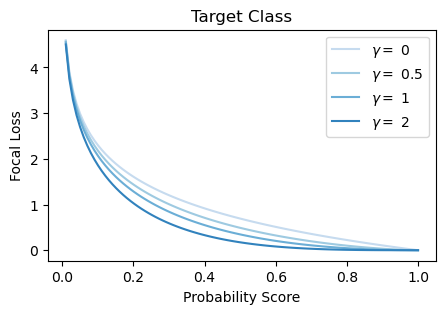

In [49]:
# Focal Loss weighting
gamma = [0,0.5,1,2]
probs = np.linspace(0, 1, 100)
colors = CMAP_t20c[0:len(gamma)][::-1]

plt.figure(figsize=(5,3))
for idx, g in enumerate(gamma):
    target_loss = [- (1-p)**g * np.log(p) for p in probs]
    plt.plot(probs,target_loss, color=colors[idx], label=f"$\\gamma =$ {g}")

plt.legend()
plt.title('Target Class')
plt.ylabel('Focal Loss')
plt.xlabel('Probability Score')

Text(0.5, 0, 'Probability Score')

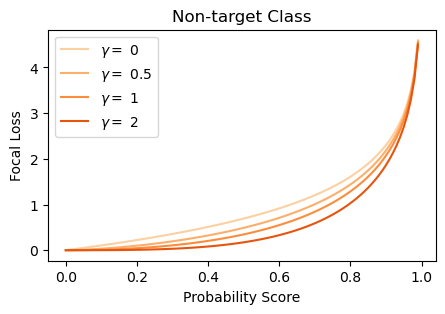

In [50]:
colors = CMAP_t20c[4:4+len(gamma)][::-1]

plt.figure(figsize=(5,3))
for idx, g in enumerate(gamma):
    non_target_loss = [- p**g * np.log(1-p) for p in probs]
    plt.plot(probs,non_target_loss, color=colors[idx], label=f"$\\gamma =$ {g}")

plt.legend()
plt.title('Non-target Class')
plt.ylabel('Focal Loss')
plt.xlabel('Probability Score')

In [4]:
def get_probs(pnts, which, net, gpu=None):

    pnts = torch.tensor(pnts).float()
    if gpu is not None and torch.cuda.is_available():
        pnts = pnts.to(f'{gpu}')

    result = net.deep_feature_forward(pnts)
    if which == 'OvR':
        probs = F.sigmoid(result).detach()
    elif which == 'OpenSetOvR':
        osovr_act = losses.OpenSetOvR(sigma=8)
        probs = osovr_act(result).detach()
    else:
        probs = F.softmax(result, dim=1).detach()
    probs = torch.max(probs, dim=1).values

    if gpu is not None and torch.cuda.is_available():
        probs = probs.cpu()
    
    return probs

In [ ]:
which = 'OvR'       # 'OpenSetOvR'        'SoftMax'       'EOS'
net = 'LeNet_plus_plus'

net = evals.load_network(args, config, which, num_classes, is_osovr=which=='OpenSetOvR', seed = seed) # 
if net is None:
    print(f"Weights are not loaded on the network!\n{which} Evaluation Terminated\n")
    continue
tools.device(net)

fig, ax = plt.subplots(figsize=(6, 6))
try:
    # min_x, max_x = np.min(pos_features[:, 0]), np.max(pos_features[:, 0])
    # min_y, max_y = np.min(pos_features[:, 1]), np.max(pos_features[:, 1])
    max_x = 10
    max_y = 10
    xy_range = max(max_x, max_y).item()
    x = np.linspace(-1 * xy_range * 1.5, xy_range * 1.5, 500)
    y = np.linspace(-1 * xy_range * 1.5, xy_range * 1.5, 500)
    pnts = list(itertools.chain(itertools.product(x, y)))
    pnts = np.array(pnts)

    res = get_probs(pnts, which, net)

    heat_map = ax.pcolormesh(
        x,
        y,
        np.array(res).reshape(500, 500).transpose(),
        # cmap='gray',
        cmap=mpl.colors.LinearSegmentedColormap.from_list("", ['gray','white']),
        rasterized=True,
        # shading="gray",
        shading='auto',
        vmin=0.0,
        vmax=1.0,
    )
    # fig.colorbar(heat_map, ax=ax, fraction=0.046, pad=0.04)
except Exception as error:
    print("An exception occurred:", error)